### Name:  Paul Trayers
### Student ID:  8907021

# Etivity 2: Data Preparation

Problems we are already aware of from Lab 1 and may need treatment:

- Missing values exist in some columns, zeros, or extreme/constant values e.g. -1, 999. Taking account of the expected importance of the column we may choose to impute the missing values or if we consider the number of missing values to be excessive and not easily imputable we may elect to drop the column.

- We observed that `balance`, `duration`, `pdays` and `previous` appear to contain outlier values.

## 1. Load Dataset

In [1]:
# Import python modules
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
%matplotlib inline

# Load data set
df = pd.read_csv("./bank.csv")

# Get the dimensions of the data set
print(f"Shape of source dataset: {df.shape}")

# Check a few rows
df.tail()

Shape of source dataset: (2000, 17)


age           job  marital  education default  balance housing loan  \
1995  20.0       student   single        NaN      no     2785      no   no   
1996  28.0        admin.   single  secondary      no      127      no   no   
1997  81.0       retired  married    primary      no     1154      no   no   
1998  46.0      services  married    primary      no     4343     yes   no   
1999  40.0  entrepreneur  married  secondary      no     6403      no   no   

        contact  day month  duration  campaign  pdays  previous poutcome  \
1995   cellular   16   sep       327         2     -1         0      NaN   
1996   cellular   16   sep      1334         2     -1         0      NaN   
1997  telephone   17   sep       231         1     -1         0      NaN   
1998        NaN   20   sep       185         1     -1         0      NaN   
1999   cellular   22   sep       208         2     -1         0      NaN   

     subscribed  
1995        yes  
1996        yes  
1997        yes  
1998        yes  
1999        yes

## 2. Missing Values

It is generally good practice to deal with missing values before encoding the columns, as missing values can affect the distribution of the encoded variables and may introduce bias or noise into the model.

Also avoids what would be more awkward process if done later of replacing columns with the original before then replacing with an imputed value and re-encoding.

### 2.1 Check for missing values

First check for obvious missing values indicated by NaN.

In [2]:
# create a boolean mask indicating the missing values
missing_values = df.isna()

# count the number of missing values in each column
missing_counts = missing_values.sum()

# display columns with missing values and their counts
print("Columns with missing values and their counts:\n")
for col in df.columns[missing_counts > 0]:
    print(f"{col}: {missing_counts[col]}")

Columns with missing values and their counts:

age: 12
job: 10
education: 104
contact: 191
poutcome: 454


### 2.2 Treat missing numerical fields (`age` )

In Lab1 we saw from a histogram and from descriptive statistics having mean age 41.75 years and median of 38 years that `age` is positively skewed (to the right). This together with having a minimum 18 years and maximum 93 indicates there may be outliers or extreme values at the upper end of the distribution.  

Normally, mean imputation is suitable for numerical data with approximately normal distributions, however based on the distribution being skewed (rather than symetric) we will use the median (rather than mean) to impute the missing age values. 

In [3]:
# Replace missing `age` values with median
df['age'].fillna(df['age'].median(), inplace=True)

### 2.3 Treat missing Ordinals ( `education`)

We saw from Lab1 that secondary education is the most common category followed by tertiary, suggesting the education variable is skewed towards higher level education.  As this is a categorical variable with relatively small number of missing values ~5% we can impute with the **mode** (highest frequency value)

In [4]:
def replace_missing_with_mode(df, cols):
    for col in cols:
        # Find the value with the highest frequency (mode)
        mode_value = df[col].value_counts().idxmax()
        # Print the mode value and count
        print(f"{col} mode (highest frequency):\n {mode_value} ({(df[col] == mode_value).sum()})")
    
        # Treat by replacing missing values with mode
        df[col].fillna(mode_value, inplace=True)
        
        # Validate
        print("\nValidate treatment..")
        print(f"{df.value_counts([col])}")
        print(f"\nTotal: {df[col].count()}")

In [5]:
replace_missing_with_mode(df, ['education'])

education mode (highest frequency):
 secondary (995)

Validate treatment..
education
secondary    1099
tertiary      684
primary       217
dtype: int64

Total: 2000


Validation above shows the ordinal positions are preserved which avoids bias creeping in.

### 2.4 Treat missing Nominals (`job`, `contact`)

Despite the proportion of missing `job` values being only 0.5% we want to avoid simply deleting the rows to preserve data having a relative small number of examples.  However there are 11 different values with frequency of top 3 fairly close so mode imputation is not an obvious solution. 

For now we will drop the rows however will review in any model evaluation phase to compare results with ignoring the missing data.

In [6]:
# drop rows with missing values in the "job" column
df = df.dropna(subset=['job'])

In the case of `contact` missing values comprise almost 10% of the data. Given that we have a fairly limited amount of data we will take a conservative approach of not dropping rows but use mode imputation.

In [7]:
replace_missing_with_mode(df, ['contact'])

contact mode (highest frequency):
 cellular (1655)

Validate treatment..
contact  
cellular     1845
telephone     145
dtype: int64

Total: 1990


### 2.5 Check for high frequency values
Check for high frequency values (other than NaN) that may also indicate a missing or invalid value.

In [8]:
# display counts of values in columns where counts > x
def high_counts(cols, min_count):
    for col in cols:
        counts = df[col].value_counts(dropna=False)
        if (counts > min_count).any():
            print(f"Counts of values > {min_count} in {col}:")
            print(counts)
            print()

high_counts(df, 100)

Counts of values > 100 in job:
management       461
technician       348
blue-collar      298
admin.           247
services         165
retired          162
student           96
unemployed        69
self-employed     64
entrepreneur      45
housemaid         35
Name: job, dtype: int64

Counts of values > 100 in marital:
married     1105
single       670
divorced     215
Name: marital, dtype: int64

Counts of values > 100 in education:
secondary    1092
tertiary      683
primary       215
Name: education, dtype: int64

Counts of values > 100 in default:
no     1975
yes      15
Name: default, dtype: int64

Counts of values > 100 in housing:
no     1029
yes     961
Name: housing, dtype: int64

Counts of values > 100 in loan:
no     1740
yes     250
Name: loan, dtype: int64

Counts of values > 100 in contact:
cellular     1845
telephone     145
Name: contact, dtype: int64

Counts of values > 100 in day:
8     203
29    187
2     155
4     148
5     104
3      93
28     92
6      92
30     

#### 2.5.1 Analysis

We observe that in addition to NaNs found previously we have additional (suspicious) high frequency values 

|Value | Col        |Count|
|---   |---         |---|
| NaN  | poutcome   |454|
|  0   | previous   |454|
| -1   | pdays      |454|

We can see that 454 of the total rows (23%) are missing values. From their descriptions we can assume these all relate to data gathered from the previous campaign;

* `pdays`: number of days that passed by after the client was last contacted from a previous campaign
* `poutcome`: outcome of the previous marketing campaign
* `previous`: number of contacts performed before this campaign and for this client

#### 2.5.2 Treat missing values

Next we decide what to do with each column with missing values;

* `pdays` has > 20% missing values (23%) and does not have any corresponding field for the current campaign so it will be dropped.
* `poutcome` having > 20% missing values (23%) but might be related to `success` however any relationship is unclear, so we will drop.
* `previous` has > 20% missing values (23%) but is equivalent to `campaign` - a new total field can be derived from both and `pdays` dropped.

Note that the above could be considered an aggessive treatment of `pdays`. A more conservative treatment might be 
to replace missing value with median as follows;
```
df['pdays'] = df['pdays'].replace(-1, np.nan)          # find -1 and replace with NaN
df['pdays'] = df['pdays'].fillna(df['pdays'].median()) # replace NaN with median
```
Ultimately, evaluating with the model and comparing results of both techniques is desirable. 

In [9]:
# poutcome column has more than 20% missing values, hence dropping
df.drop(['pdays', 'poutcome'], axis=1, inplace=True) ;

In [10]:
df.tail()

age           job  marital  education default  balance housing loan  \
1995  20.0       student   single  secondary      no     2785      no   no   
1996  28.0        admin.   single  secondary      no      127      no   no   
1997  81.0       retired  married    primary      no     1154      no   no   
1998  46.0      services  married    primary      no     4343     yes   no   
1999  40.0  entrepreneur  married  secondary      no     6403      no   no   

        contact  day month  duration  campaign  previous subscribed  
1995   cellular   16   sep       327         2         0        yes  
1996   cellular   16   sep      1334         2         0        yes  
1997  telephone   17   sep       231         1         0        yes  
1998   cellular   20   sep       185         1         0        yes  
1999   cellular   22   sep       208         2         0        yes

## 3. Derived Fields

### 3.1 Holiday periods (`day_of_year`)

We assume particular times of year are significant for a direct marketing campaign e.g. holiday periods.

Therefore we create a feature combining the month and day of month to create `day_of_year`.

In [11]:
# First use LabelEncoder to encode month to an integer
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['month'] = encoder.fit_transform(df['month'])

# create day_of_year column by concatenating month and day_of_month
# pad single character months/days with leading zeros
df['day_of_year'] = \
df['month'].apply(lambda x: str(x).zfill(2)) + \
df['day'].apply(lambda x: str(x).zfill(2))

# Convert "day_of_year" to a numeric column
df['day_of_year'] = pd.to_numeric(df['day_of_year'])

### 3.2 Total contacts (`total_contacts`)

Since we saw that `previous` has many missing value but is similar to `category`, we will do following;
* Create a new feature `total_days` as the sum of `campaign` and `previous`
* Drop column `previous` because it can be derived from `total_contacts` and `campaign`.

In [12]:
# Create a new column by adding the values in column1 and column2
df['total_contacts'] = df['campaign'] + df['previous']

# Drop pdays from the dataframe
df.drop('previous', axis=1, inplace=True)

In [13]:
df.tail()

age           job  marital  education default  balance housing loan  \
1995  20.0       student   single  secondary      no     2785      no   no   
1996  28.0        admin.   single  secondary      no      127      no   no   
1997  81.0       retired  married    primary      no     1154      no   no   
1998  46.0      services  married    primary      no     4343     yes   no   
1999  40.0  entrepreneur  married  secondary      no     6403      no   no   

        contact  day  month  duration  campaign subscribed  day_of_year  \
1995   cellular   16     11       327         2        yes         1116   
1996   cellular   16     11      1334         2        yes         1116   
1997  telephone   17     11       231         1        yes         1117   
1998   cellular   20     11       185         1        yes         1120   
1999   cellular   22     11       208         2        yes         1122   

      total_contacts  
1995               2  
1996               2  
1997               1  
1998               1  
1999               2

### 3.3 Further derived fields

Some ideas for potential further derived fields (not implemented);

* A derived field representing some credit score metric might be derived from some combination of `balance`, `housing`, `loan`, `default`.

* `age bands` could be created and combined with another derived fields for 'professional' jobs e.g.
  * `age_band`: ordinal `18-34`, `34-45`, `45-65`, `65+` 
  * `professional`: boolean IF job in[`services`, `management`, `entrepreneur`]
* Then further derived field `profile` might concatenate these e.g. young graduate professional or middle-aged manager - my thought is that certain profiles might be more likely to subscribe and so could be better targeted by marketing.
* Also in next section we implement `month_freq` to encode the frequency of `month` field. 

* When creating multiple additional fields we need to keep in mind the VC dimension rule is still observed in terms of number of required samples for generalized learning to occur.

## 4. Encode Categorical Features

### 4.1 Encode Ordinals 

Identifying columns with an inherent order.

* `education` has as inherent order  i.e. primary, secondary, tertiary.
* `month` has an inherent order  i.e. jan, feb, mar, ..., oct, nov, dec. We should also note it is cyclical.
* `day` and `day_of_year` have inherent order.

### 4.2 Encode `education`

`education` has as inherent order  i.e. primary, secondary, tertiary. We will use integer encoding.

In [14]:
# define the ordering of the categories
education_ordering = ['primary', 'secondary', 'tertiary']

# encode the ordinal variable using integer encoding...
# this technique uses a lambda (headless) function which iterate each of the column values 
# setting each to its corresponding index from the array
df['education'] = df['education'].apply(lambda i: education_ordering.index(i))

# alternative technique (shown here for reference but not called)...
# Create an scale mapper object for education
education_scale_mapper = {
    "primary" : 1,
    "secondary" : 2,
    "tertiary" : 3
}
# Encode `education` field
#df['education'] = df['education'].replace(education_scale_mapper)

### 4.3 Encode `month`

`month` has an inherent order  i.e. jan, feb, mar, ..., oct, nov, dec. 

We should also note it is cyclical therefore we will use cyclical encoding referenced [here](https://towardsdatascience.com/how-to-handle-cyclical-data-in-machine-learning-3e0336f7f97c).

In [15]:
# First use LabelEncoder to encode month to an integer
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['month'] = encoder.fit_transform(df['month'])

# Create sin and cos columns.
df['sin_month'] = np.sin(2 * np.pi * df['month'] / max(df['month'])) 
df['cos_month'] = np.cos(2 * np.pi * df['month'] / max(df['month']))
# Drop `month` later after join it with `day` to derived new field. 

### 4.4 Encode (derive) `month_freq`

We will also apply frequency encoding based on the hypothesis that month of year may be a significant factor in subscribing.

In [16]:
# Calculate the frequency of each category
freq = df['month'].value_counts(normalize=True)

# Create a dictionary to map categories to their frequency
freq_dict = freq.to_dict()

# Apply the frequency encoding to the column
df['month_freq'] = df['month'].map(freq_dict)

# Drop month from the dataframe
df.drop('month', axis=1, inplace=True)

### 4.5 Encode `day` and `day_of_year`

Apply similar cyclical encoding to `day` and `day_of_year`

In [17]:
# Create sin and cos columns.
df['sin_day'] = np.sin(2 * np.pi * df['day'] / max(df['day'])) 
df['cos_day'] = np.cos(2 * np.pi * df['day'] / max(df['day']))
df.drop('day', axis=1, inplace=True)  # Drop day from the dataframe

In [18]:
# Create sin and cos columns.
# @TODO: Debug...
df['sin_day_of_year'] = np.sin(2 * np.pi * df['day_of_year'] / max(df['day_of_year'])) 
df['cos_day_of_year'] = np.cos(2 * np.pi * df['day_of_year'] / max(df['day_of_year']))
df.drop('day_of_year', axis=1, inplace=True)  # Drop day_of_year from the dataframe

### 4.6 One-Hot Encode Nominal Categorical Attributes

Since we already dealt with missing values we can apply one-hot encoding directly on all categorical columns without requiring parameter {{dummy_na=True}} to create additional missing value columns

In [19]:
#df = pd.get_dummies(df, columns=['marital', 'job', 'contact'], 
#                        dummy_na=True, # Add column for missing values
#                        drop_first=True)

# one-hot encode all categorical columns
df = pd.get_dummies(df, drop_first=True)

pd.set_option('display.max_columns', 50) # display up to 50 columns

In [20]:
df.tail()

age  education  balance  duration  campaign  total_contacts  \
1995  20.0          1     2785       327         2               2   
1996  28.0          1      127      1334         2               2   
1997  81.0          0     1154       231         1               1   
1998  46.0          0     4343       185         1               1   
1999  40.0          1     6403       208         2               2   

         sin_month  cos_month  month_freq   sin_day   cos_day  \
1995 -1.133108e-15        1.0    0.066332 -0.101168 -0.994869   
1996 -1.133108e-15        1.0    0.066332 -0.101168 -0.994869   
1997 -1.133108e-15        1.0    0.066332 -0.299363 -0.954139   
1998 -1.133108e-15        1.0    0.066332 -0.790776 -0.612106   
1999 -1.133108e-15        1.0    0.066332 -0.968077 -0.250653   

      sin_day_of_year  cos_day_of_year  job_blue-collar  job_entrepreneur  \
1995        -0.072285         0.997384                0                 0   
1996        -0.072285         0.997384                0                 0   
1997        -0.066734         0.997771                0                 0   
1998        -0.050066         0.998746                0                 0   
1999        -0.038947         0.999241                0                 1   

      job_housemaid  job_management  job_retired  job_self-employed  \
1995              0               0            0                  0   
1996              0               0            0                  0   
1997              0               0            1                  0   
1998              0               0            0                  0   
1999              0               0            0                  0   

      job_services  job_student  job_technician  job_unemployed  \
1995             0            1               0               0   
1996             0            0               0               0   
1997             0            0               0               0   
1998             1            0               0               0   
1999             0            0               0               0   

      marital_married  marital_single  default_yes  housing_yes  loan_yes  \
1995                0               1            0            0         0   
1996                0               1            0            0         0   
1997                1               0            0            0         0   
1998                1               0            0            1         0   
1999                1               0            0            0         0   

      contact_telephone  subscribed_yes  
1995                  0               1  
1996                  0               1  
1997                  1               1  
1998                  0               1  
1999                  0               1

## 5. Rescaling Features

The most common approaches to scaling are;

* Min-max scaling: This method scales the values in a column to a range of 0 to 1. To do this, you subtract the minimum value in the column from each value and then divide by the range (the difference between the maximum and minimum values). The formula is:
`
(x - min(x)) / (max(x) - min(x))
`

* Standardization: This method scales the values in a column to have a mean of 0 and a standard deviation of 1. To do this, you subtract the mean from each value and then divide by the standard deviation. The formula is:
`
(x - mean(x)) / std(x)
`
* Log transformation: This method is used when the values in the column are skewed or have a wide range of values. A log transformation can help normalize the distribution of the data. To do this, you take the natural logarithm of each value in the column. The formula is:
`
log(x)
`

Given above we now examine distibutions and outliers for relevant fields...

### 5.1 Remove extreme outliers

We previously observed `balance` has an extreme outlier far outside the IQR(+/-)1.5 which we will simply remove to minimise scale distortion.

In [21]:
# Calculate the z-score for each value in the column
z_scores = (df['balance'] - df['balance'].mean()) / df['balance'].std()

# Identify the index of the row containing the outlier value
outlier_index = z_scores.abs().idxmax()
print(f"Removing balance of {df['balance'][outlier_index]} having z-score {z_scores.abs().max()}")
# Remove the row containing the outlier value
df = df.drop(outlier_index)
df_original = df.copy(deep=True)  # deep copy

Removing balance of 81204 having z-score 25.42331858383995


### 5.2 Check outliers

We will regard values lying outside the inter-quartile range IQR(+/-)1.5 as potential outliers but may re-visit to apply more contect specific definitions. First checking visually with boxplots.. 

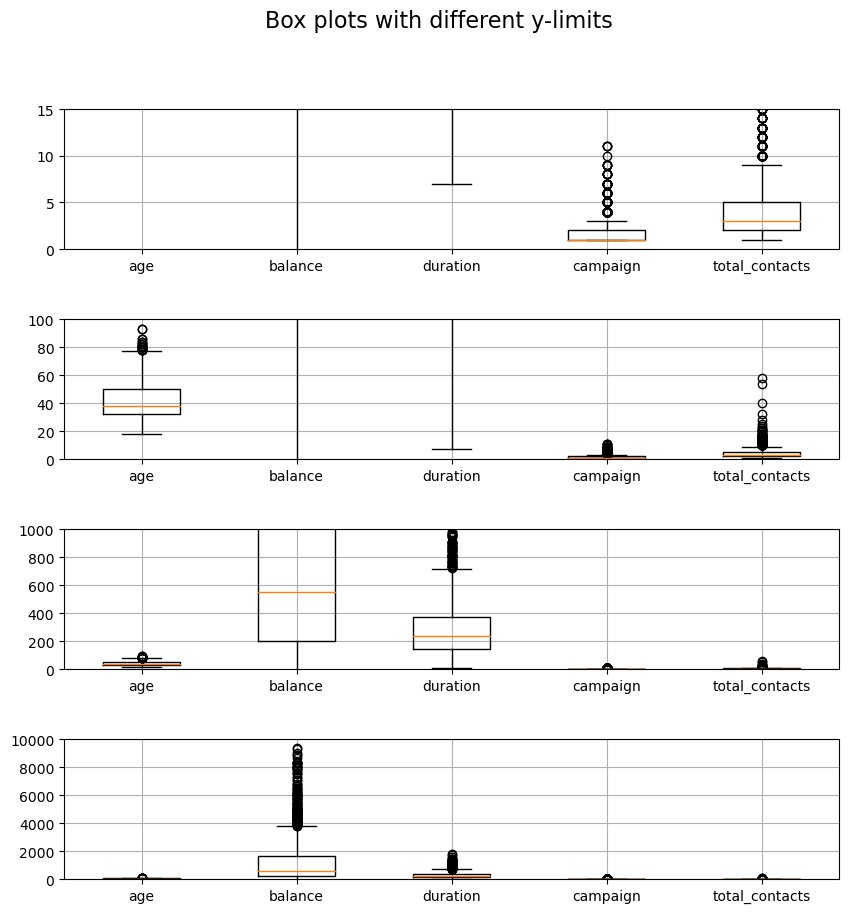

In [22]:
# Create a figure with 4 subplots arranged vertically
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 10))

# Create a box plot for each dataset and add it to the corresponding subplot
cols=['age','balance', 'duration', 'campaign', 'total_contacts']
axes[0].set_ylim(0, 15);    axes[0].boxplot(df[cols])
axes[1].set_ylim(0, 100);   axes[1].boxplot(df[cols])
axes[2].set_ylim(0, 1000);  axes[2].boxplot(df[cols])
axes[3].set_ylim(0, 10000); axes[3].boxplot(df[cols])

# Set titles and labels for each subplot
axes[0].set_xticklabels(cols); axes[0].grid(True)
axes[1].set_xticklabels(cols); axes[1].grid(True)
axes[2].set_xticklabels(cols); axes[2].grid(True)
axes[3].set_xticklabels(cols); axes[3].grid(True)

# Add an overall title to the figure
fig.suptitle('Box plots with different y-limits', fontsize=16)

# Add some spacing between the subplots
plt.subplots_adjust(hspace=0.5)
plt.show()

Next checking through calculation...

Calculate the IQR of each column being the difference between third quartile (Q3) and first quartile (Q1). Any data point outside the range of (Q1 - 1.5 * IQR) and (Q3 + 1.5 * IQR) is considered an outlier.

In [23]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

Identify columns having outliers using boolean mask to select rows with at least one outlier..

In [24]:
outlier_filter = (df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))
outlier_columns = df.columns[outlier_filter.any()]
print(outlier_columns)

Index(['age', 'balance', 'duration', 'campaign', 'total_contacts',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'default_yes',
       'loan_yes', 'contact_telephone'],
      dtype='object')


Above provides the names of the columns that have outliers.

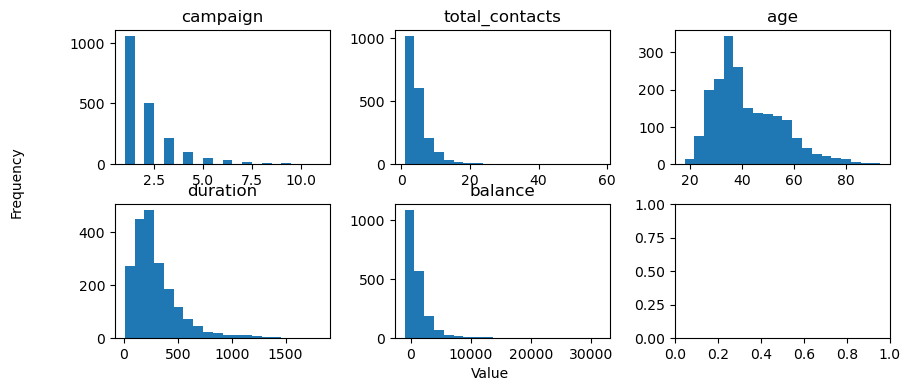

In [25]:
# Create a figure with three subplots
fig, axs = plt.subplots(2, 3, figsize=(10, 4))

# Plot the histograms in each subplot
axs[0,0].hist(df['campaign'], bins=20)
axs[0,1].hist(df['total_contacts'], bins=20)
axs[0,2].hist(df['age'], bins=20)
axs[1,0].hist(df['duration'], bins=20)
axs[1,1].hist(df['balance'], bins=20)

# Set titles for each subplot
axs[0,0].set_title('campaign')
axs[0,1].set_title('total_contacts')
axs[0,2].set_title('age')
axs[1,0].set_title('duration')
axs[1,1].set_title('balance')

# Add a common x-axis label and y-axis label for the entire figure
fig.text(0.5, 0.01, 'Value', ha='center')
fig.text(0.02, 0.5, 'Frequency', va='center', rotation='vertical')

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# Show the plot
plt.show()

### 5.2.1 Observations

* `campaign` - severe skew (+ve) distribution with long tail with outliers.
* `total_contacts` - heavily skewed normal distibution with outliers.
* `age` - slightly skewed normal distribution with outliers.
* `duration` - moderate/severe skew (+ve) distribution with outliers.
* `balance` - moderate/severe skew, many outliers.

The remaining fields are binary many having been one-hot encoded.

### 5.3 Apply Rescaling
Below are the most common `scikit-learn` re-scaling techniques we can to apply to the approachs mentioned in the introduction to this section;

* MinMaxScaler - rescales to interval [0,1]. Most appropriate for data that known to be positive with a known upper bound, but can be sensitive to outliers which will cause distortion.
* StandardScaler - rescales so has mean 0 and standard deviation 1. Appropriate for normally distributed data without significant outliers.
* RobustScaler - does a better job in the presence of outliers by subtracting the median and dividing by IQR.

### 5.3.1 Normal fields (`age`)
`age` although slightly skewed has a normal distribution without significant outliers. We will also evaluate to compare with RobustScaler to determine if any performance difference. 

In [26]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

standard_scaler = StandardScaler()
normal_cols = ['age'] 
df[normal_cols] = standard_scaler.fit_transform(df[normal_cols])

### 5.3.2 Non-Normal fields (`balance`, `duration`)
These fields are moderate/severely skewed with significant outliers.

In [27]:
### Non-normal fields with outliers
robust_scaler = RobustScaler()
skewed_with_outlier_cols = ['balance', 'duration'] 
df[skewed_with_outlier_cols] = robust_scaler.fit_transform(df[skewed_with_outlier_cols])

### 5.4 Check bounded ranges

Check for fields with well-defined upper bounds which may be suitable for re-scaling with MaxScaler. 'day' and 'month' fields might have been candidates but already dealt with by cyclical encoding.

In [28]:
# Get max and min values for each field
max_values = df.max()
min_values = df.min()

# Print the max and min values for each field
print("Maximum values:")
print(max_values)
#print("\nMinimum values:")
#print(min_values)

Maximum values:
age                   4.057923
education             2.000000
balance              21.594274
duration              6.930131
campaign             11.000000
total_contacts       58.000000
sin_month             0.989821
cos_month             1.000000
month_freq            0.202010
sin_day               0.998717
cos_day               1.000000
sin_day_of_year       0.993966
cos_day_of_year       1.000000
job_blue-collar       1.000000
job_entrepreneur      1.000000
job_housemaid         1.000000
job_management        1.000000
job_retired           1.000000
job_self-employed     1.000000
job_services          1.000000
job_student           1.000000
job_technician        1.000000
job_unemployed        1.000000
marital_married       1.000000
marital_single        1.000000
default_yes           1.000000
housing_yes           1.000000
loan_yes              1.000000
contact_telephone     1.000000
subscribed_yes        1.000000
dtype: float64


In [29]:
# Instantiate MinMaxScaler object
scaler_minmax = MinMaxScaler()

# Rescale day of month field
#df['day'] = scaler_minmax.fit_transform(df[['day']])
#df['month'] = scaler_minmax.fit_transform(df[['month']])
#df['day_of_year'] = scaler_minmax.fit_transform(df[['day_of_year']])  @TODO


(Alternative more manual approach...)
* To bring column `education` to the interval $[0,1]$ we can simply divide it by 2, as it is an ordinal columns with four possible values: 0, 1, and 2.
* To bring column `month` to the interval $[0,1]$ we can simply divide it by 12, as it is an ordinal columns with four possible values: 0 to 11.
* Bring `day` (day of month) to the interval [0,1] using MinMaxScaler since it has an upper bound of 31

In [30]:
#df['education'] = df['education'] / 2
#df['month'] = df['month'] / 12

In [31]:
df.tail()

age  education   balance  duration  campaign  total_contacts  \
1995 -1.713664          1  1.561453  0.397380         2               2   
1996 -1.081161          1 -0.294693  4.794760         2               2   
1997  3.109169          0  0.422486 -0.021834         1               1   
1998  0.341970          0  2.649441 -0.222707         1               1   
1999 -0.132407          1  4.087989 -0.122271         2               2   

         sin_month  cos_month  month_freq   sin_day   cos_day  \
1995 -1.133108e-15        1.0    0.066332 -0.101168 -0.994869   
1996 -1.133108e-15        1.0    0.066332 -0.101168 -0.994869   
1997 -1.133108e-15        1.0    0.066332 -0.299363 -0.954139   
1998 -1.133108e-15        1.0    0.066332 -0.790776 -0.612106   
1999 -1.133108e-15        1.0    0.066332 -0.968077 -0.250653   

      sin_day_of_year  cos_day_of_year  job_blue-collar  job_entrepreneur  \
1995        -0.072285         0.997384                0                 0   
1996        -0.072285         0.997384                0                 0   
1997        -0.066734         0.997771                0                 0   
1998        -0.050066         0.998746                0                 0   
1999        -0.038947         0.999241                0                 1   

      job_housemaid  job_management  job_retired  job_self-employed  \
1995              0               0            0                  0   
1996              0               0            0                  0   
1997              0               0            1                  0   
1998              0               0            0                  0   
1999              0               0            0                  0   

      job_services  job_student  job_technician  job_unemployed  \
1995             0            1               0               0   
1996             0            0               0               0   
1997             0            0               0               0   
1998             1            0               0               0   
1999             0            0               0               0   

      marital_married  marital_single  default_yes  housing_yes  loan_yes  \
1995                0               1            0            0         0   
1996                0               1            0            0         0   
1997                1               0            0            0         0   
1998                1               0            0            1         0   
1999                1               0            0            0         0   

      contact_telephone  subscribed_yes  
1995                  0               1  
1996                  0               1  
1997                  1               1  
1998                  0               1  
1999                  0               1

## 6. Treatment of Outliers (`balance`, `duration`, `campaign`, `total_contacts`)

We noted presence of outliers from boxplots and histograms above in fields `balance`, `duration`, `campaign`, `total_contacts`. Their histograms are positively skewed however, algorithms work better when the features are not skewed.

`age` also has outliers based on IQR however since the skew is slight/moderate we will not treat for now, however may be further evaluated.

Before treating, first find minimum values in these columns..

In [32]:
df[['balance', 'duration', 'campaign', 'total_contacts']].min()

balance          -1.067737
duration         -1.000000
campaign          1.000000
total_contacts    1.000000
dtype: float64

### 6.2 Log Transformation

Since the extreme values is practically possible in balance, i.e. overdraft we can transform the negative impact of outliers to ML models by applying log transformation. However we first need to shift this `balance` to a positive range before applying a log transformation. 

In [33]:
# create a boolean mask indicating the missing values
missing_values = df.isna()

# count the number of missing values in each column
missing_counts = missing_values.sum()

# display columns with missing values and their counts
print("Columns with missing values and their counts:\n")
for col in df.columns[missing_counts > 0]:
    print(f"{col}: {missing_counts[col]}")

Columns with missing values and their counts:



In [34]:
# Use a log transformation to decrease the impact of outliers

min_adj = 0.001 # adding to avoid division by zero
df['balance'] = np.log(df['balance'] + df['balance'].min() + min_adj)
df['duration'] = np.log(df['duration'] + df['duration'].min() + min_adj)
df['balance'] = np.log(df['balance'])
df['duration'] = np.log(df['duration'])                    
                       
df['campaign'] = np.log(df['campaign'])
df['total_contacts'] = np.log(df['total_contacts'])

/opt/anaconda3/envs/env-ul-course-data-analytics/lib/python3.9/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Re-plotting following log transformation.

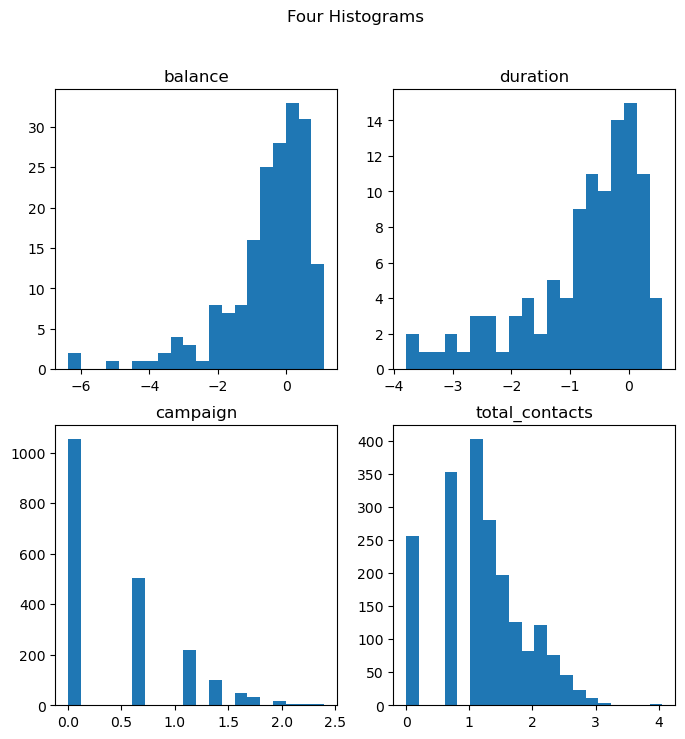

In [35]:
# create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

# plot the histograms in each subplot
axs[0, 0].hist(df['balance'], bins=20)
axs[0, 0].set_title('balance')

axs[0, 1].hist(df['duration'], bins=20)
axs[0, 1].set_title('duration')

axs[1, 0].hist(df['campaign'], bins=20)
axs[1, 0].set_title('campaign')

axs[1, 1].hist(df['total_contacts'], bins=20)
axs[1, 1].set_title('total_contacts')

# add a title to the figure
fig.suptitle('Four Histograms')

plt.show()

Apart from `campaign` the histograms show transformed features less skewed having distributions closer to normal than the original features.

### 6.2  `campaign` as ordinal

The above log transformation had no impact on `campaign`, so examining the distribution of values...

In [36]:
df_original['campaign'].value_counts()

1     1055
2      504
3      218
4       99
5       50
6       31
7       17
8        6
9        5
11       3
10       1
Name: campaign, dtype: int64

`campaign` appears to be more ordinal rather than continuous numerical feature with more than 50% of its values being 1063. Some of its values do appear to be actual outliers. To bring it to the interval $[0,1]$ we can divide all values by 11 (effectively applying MinMaxScaler to it). 

We verified that applying RobustScaler and log transformation to it instead caused it to become more skewed to the right.

In [37]:
#df[skewed_with_outlier_cols] = 
df['campaign'] = robust_scaler.fit_transform((df_original[['campaign']].copy())) / 11

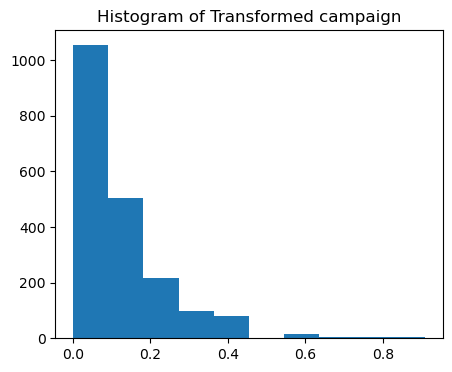

In [38]:
# plot histogram of column 'campaign'
fig, ax = plt.subplots(figsize=(5, 4))
ax.hist(df['campaign'])
ax.set_title('Histogram of Transformed campaign')
plt.show()

# G. Save the Prepared Dataset

Finally, let's save the prepared dataset as a CSV file.

In [39]:
df.to_csv('loans_train_prepared.csv')